In [1]:
import mysql.connector
import pandas as pd
from datetime import datetime, timedelta

In [2]:
db_connection = mysql.connector.connect(
  host= "wp.jagi.wtf",
  user= "redditu",
  password= "redditMaster",
  database="reddit"
  )
cursor = db_connection.cursor()

In [3]:
df = pd.read_sql("SELECT * FROM reddit", db_connection)

In [4]:
df["day_created"] = pd.to_datetime(df["day_created"]).dt.date
df["time_created"] = pd.to_datetime(df["time_created"]).dt.time
df["curr_time"] = pd.to_datetime(df["curr_time"])

dtstuff = df.apply(
    lambda row: datetime.combine(row['day_created'], row['time_created']),
    axis=1
)
df["time"] = dtstuff

df["time"] = df["time"] - timedelta(hours=10) # weil Jakob verkackt hat, die Daten in UTC Zeit zu speichern :(
df["post_id"] = df.agg('{0[author]}-{0[time]}'.format, axis=1) # dauert lange, ist aber wichtig

In [5]:
df.drop(inplace = True, columns=['id', 'hour_created', 'time_created', 'day_created',
                                 'downs', 'num_comments', 'text', 'thumbnail', 'url', 'curr_time', 'time'])

df.drop_duplicates(inplace = True, subset=['post_id'])

In [6]:
backup = df

In [7]:
df.head()

,author,title,ups,post_id
0,daynestxbbq,[PRO/CHEF] Texas Barbecue Platter,43666,daynestxbbq-2021-02-07 22:48:37
1,jojofaye,[homemade] Whole lemon cake doughnuts with whi...,2508,jojofaye-2021-02-07 17:19:56
2,will20566,[Homemade] Calamari,848,will20566-2021-02-07 21:18:47
3,aka_scoch,[homemade] raspberry cream cake covered in Legos,18446,aka_scoch-2021-02-07 08:49:38
4,Untoastedtoast390,[homemade] “yogurt eggs and apple fries”,1313,Untoastedtoast390-2021-02-07 18:15:36


## Top Author finden

Attribut1: durchschnittliche Upvotes (möglichst hoch) [>0.9 Quantil]

Attribut2: Standardabweichung (möglichst klein) [<0.1 Quantil]

logische UND-Verbindung aus beiden Merkmalen und dann nachsehen, wie viele Autoren übrig bleiben. 

So lange das Quantil verkleinern, bis 3-10 Autoren übrig bleiben. Dann Top-Autoren ins Detail nehmen. 

Haben die vielleicht etwas besonderes in ihrer Bio stehen? 

Sind das Mods in r/food? Was sind das für Personen? Wo posten die sonst noch? Vorstellung der Charaktere


In [8]:
df = backup

In [9]:
# durchschnittliche Upvotes
# gesamte Upvotes
ups_total = df['ups'].groupby(df['author']).sum()
df['ups_total'] = df['author'].map(ups_total)

# Anzahl der Posts
posts_total = df['ups'].groupby(df['author']).count()
df['posts_total'] = df['author'].map(posts_total)

# drop authors with only 1 post
df.drop(index=df[df['posts_total'] == 1].index, inplace=True)

# Durchschnittlicher Erfolg
df['avg_ups'] = df['ups_total'] / df['posts_total']

# Standardabweichung
ups_std = df['ups'].groupby(df['author']).std()
df['ups_std'] = df['author'].map(ups_std)

In [10]:
df.head()

,author,title,ups,post_id,ups_total,posts_total,avg_ups,ups_std
0,daynestxbbq,[PRO/CHEF] Texas Barbecue Platter,43666,daynestxbbq-2021-02-07 22:48:37,43685,3,14561.666667,25205.092032
3,aka_scoch,[homemade] raspberry cream cake covered in Legos,18446,aka_scoch-2021-02-07 08:49:38,18460,3,6153.333333,10645.761801
6,Sclerodermasucks17,[Homemade] Eggs and Everything,1926,Sclerodermasucks17-2021-02-07 15:52:44,2052,4,513.000000,943.192805
7,bachuket,[I ate] Korean corndogs!,2733,bachuket-2021-02-07 14:06:11,2773,6,462.166667,1112.479288
8,sugurkewbz,[HOMEMADE] Fudge brownies with dark chocolate ...,747,sugurkewbz-2021-02-07 20:25:39,1312,6,218.666667,334.255391


In [11]:
# select 2 df
#df[df['avg_ups'] > df['avg_ups'].quantile(.95)]['ups_total'].min()
avg_df = df[df['avg_ups'] > df['avg_ups'].quantile(.95)]
std_df = df[df['ups_std'] < df['ups_std'].quantile(.99)]

top_author = pd.merge(std_df, avg_df, on='author')
print('Anzahl Autoren:',top_author['author'].count())
print('Autoren: ',top_author['author'].unique())

top_author = df[df['author'].isin(top_author['author'].unique())].sort_values(by='ups_total', ascending=False)
top_author.drop_duplicates(inplace=True, subset='author')
top_author.drop(inplace = True, columns=['post_id', 'title', 'ups'])
top_author

Anzahl Autoren: 3656
Autoren:  ['sugurkewbz' 'sonofman888' 'kay_lerr' 'Joshtice' 'muh-liss' 'Razultull'
 'originalarcmoon' 'zyphersd' 'chewy_pnt' 'StormySMommi' 'Mel_Zetz'
 'LittlePupper69' 'Ken-dee-rah' 'revisedbusmall' 'ryanvenema' 'DumbestBoy'
 'mariapronina' 'crawlspeed' 'fazik93' 'Mortadelllla' 'Newtothis1968'
 'budgetmeatball' 'DrDankologist' 'friedtummis' 'TheLadyEve' 'ThePieous'
 'Second_Woodsman' 'HerculesMulligatawny' 'Coombsey02' 'SoonerMagic10'
 'rossposse' 'violetpiano' 'MayushiiBestGurl' 'IamAllAboutFood'
 'iluvpotions' 'lilbismyfriend2013' 'bpip18' 'kllylwrnc' 'mikopotato1995'
 'iKorith' 'Robbored' 'tipsyzeke' 'price0416' 'Billtheguide' 'NeilCaf22'
 'ekthc' 'silverrizzla' 'DField118' 'thisismybakingreddit' 'ohmy1027'
 'Turtle9015' 'flexflexson' 'jamieldavies93' 'BurtDBurt' 'NillaWayfarer'
 'ChurchOfTheBrokenGod' 'blessantsblants' 'nguzma411' 'treasuredmeat'
 'DanasPaperFlowers' 'wrayngler' 'Itsme66604' 'edubkendo'
 'turkey_sandwich87' 'mrsfran' 'lundrog' 'Cromeon' 'kytra

,author,ups_total,posts_total,avg_ups,ups_std
788471,SoonerMagic10,1881,35,53.742857,180.771768
8,sugurkewbz,1312,6,218.666667,334.255391
711184,kytran40,1080,16,67.500000,160.335482
610027,triplecute,869,9,96.555556,212.442410
203671,sonofman888,817,4,204.250000,392.502548
...,...,...,...,...,...
374233,Turtle9015,65,2,32.500000,20.506097
412095,ChurchOfTheBrokenGod,64,2,32.000000,29.698485
729369,ryanvenema,63,2,31.500000,31.819805
265584,price0416,62,2,31.000000,29.698485


## Die Besten Poster

Kriterien:

- Mindestens 2 Posts im Subreddit
- Top 5% der meisthochgewählten Autoren
- Durchschnittsgute User (untere 99% der Standardabweichung im Streuungsmaß)


User mit den meisten Upvotes: SoonerMagic10
- 1881 Upvotes in total, 35 posts, 53 avg upvotes

User mit den meisten durchschnittlichen Upvotes: sugurkewbz
- 1312 Upvotes in total, 6 posts, 219 avg upvotes

User mit den meisten Posts: SoonerMagic10
- 1881 Upvotes in total, 35 posts, 53avg upvotes

## Schlussfolgerung

Angesichts der Tatsache, dass die von uns als konsistent am besten bewerteten Nutzer noch relativ wenig Upvotes im Vergleich zu besten Posts haben und wenig Posts im Vergleich zu der Anzahl an Posts haben, schlussfolgern wir, dass r/food keine User besonders gegenüber anderen bevorzugt. 

Selbst ein so guter Poster hat durchschnittlich weniger Erfolg, als ein Top-Post eines jeweiligen Tages. Die Top-Posts die wir auf der Startseite in 'hot' sehen, sind somit alle für sich selbst als one-hit-wonder zu beschreiben und kein User schafft es, konsistent solche beeindruckenden Posts zu erstellen.

# 5. Anzahl der Ups in Abhängigkeit der Anzahl der Posts eines jeweiligen Autors

In [12]:
df = top_author

In [13]:
import seaborn as sns

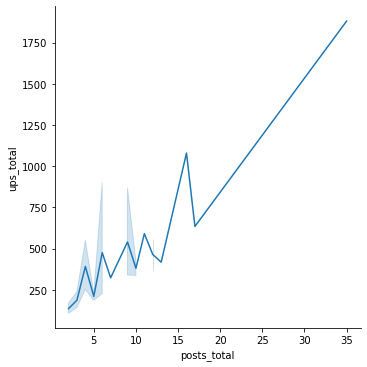

In [14]:
sns.relplot(
    data=df, kind="line",
    x="posts_total", y="ups_total")

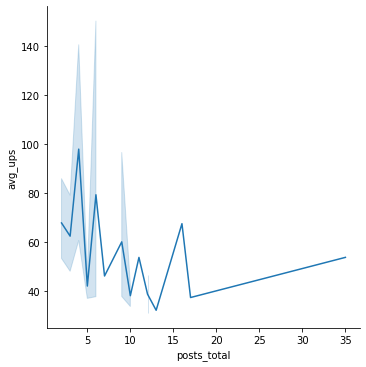

In [15]:
sns.relplot(
    data=df, kind="line",
    x="posts_total", y="avg_ups")

# 11. Anzahl der Ups über die Zeit

In [16]:
df = pd.read_sql("SELECT * FROM reddit", db_connection)

In [17]:
#df = df[:5000]

In [18]:
df['author_title'] = df['author'] + ' - ' + df['title']

In [19]:
author_title_list = df['author_title'].unique()
author_title_dict = dict.fromkeys(author_title_list)

In [20]:
# Achtung, dauert einen Moment
for author_title in author_title_list:
    #print('Working on: ', author_title)
    temp_df = df[df['author_title'] == author_title]
    
    mylist = []
    for idx, row in temp_df.iterrows():
        mylist.append(row['ups'])
    mylist.sort()
    
    author_title_dict[author_title] = mylist

In [21]:
#author_title_dict

In [22]:
author_title_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in author_title_dict.items() ]))
author_title_df = author_title_df.T
author_title_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,417,418,419,420,421,422,423,424,425,426
daynestxbbq - [PRO/CHEF] Texas Barbecue Platter,43666.0,43755.0,44115.0,44520.0,44974.0,45377.0,45779.0,46178.0,46621.0,47028.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"jojofaye - [homemade] Whole lemon cake doughnuts with white chocolate ganache, lemon curd drizzle and white chocolate shavings",2508.0,2512.0,2517.0,2518.0,2521.0,2523.0,2536.0,2543.0,2552.0,2557.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
will20566 - [Homemade] Calamari,843.0,848.0,850.0,854.0,856.0,860.0,863.0,864.0,869.0,876.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aka_scoch - [homemade] raspberry cream cake covered in Legos,18440.0,18445.0,18446.0,18446.0,18446.0,18447.0,18447.0,18447.0,18449.0,18449.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Untoastedtoast390 - [homemade] “yogurt eggs and apple fries”,1313.0,1313.0,1319.0,1322.0,1327.0,1329.0,1343.0,1348.0,1349.0,1356.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
average_post = []
for column in author_title_df.columns:
    something = author_title_df.iloc[:, column].quantile(.95)
    average_post.append(something)

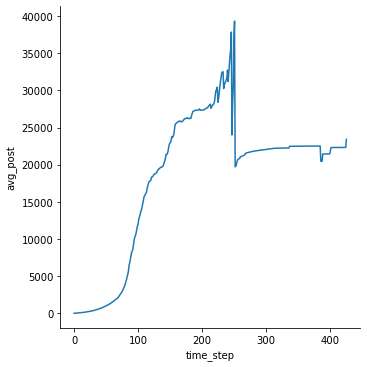

In [24]:
# Das hier ist komplett scheiße. Wenn du das liest, solltest du den unteren Ansatz reparieren plox.
# Damit hätte man dann so viele Quantile, wie man möchte im Plot.
avg_post_dict = dict.fromkeys(average_post)
for item in average_post:
    avg_post_dict[item] = average_post.index(item)

post_progression = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in avg_post_dict.items() ]))
post_progression = post_progression.T
post_progression['avg_post'] = post_progression.index
post_progression['time_step'] = post_progression.iloc[:, 0]


sns.relplot(
    data=post_progression, kind="line",
    x="time_step", y="avg_post")

In [25]:
# # https://pbpython.com/pandas-qcut-cut.html
# # garbage funktioniert nicht
# data_list = []

# for column in author_title_df.columns:
#     quantile, qcut_intervals = pd.qcut(author_title_df[column], q=5, precision=0, duplicates='drop',retbins=True)
#     data_list.append(quantile)

In [26]:
# progress_df = pd.DataFrame(data=data_list)
# progress_df.head(15)

In [27]:
# avg_post_progress = []
# for column in progress_df.columns:
#     # das hier sollte funktionieren, change my mind
#     avg_post_progress.append(progress_df[column].mean())

# Dieses scheiß letzte Statement funktioniert nicht. Und ich finde NIX dazu. Scheiß Intervalle.